# CS145 Introduction to Data Mining - Assignment 1
## Deadline: 12:00PM (noon), April 12, 2024

## Instructions
Each assignment is structured as a Jupyter notebook, offering interactive tutorials that align with our lectures. You will encounter two types of problems: *write-up problems* and *coding problems*.

1. **Write-up Problems:** These problems are primarily theoretical, requiring you to demonstrate your understanding of lecture concepts and to provide mathematical proofs for key theorems. Your answers should include sufficient steps for the mathematical derivations.
2. **Coding Problems:** Here, you will be engaging with practical coding tasks. These may involve completing code segments provided in the notebooks or developing models from scratch.

To ensure clarity and consistency in your submissions, please adhere to the following guidelines:

* For write-up problems, use Markdown bullet points to format text answers. Also, express all mathematical equations using $\LaTeX$ and avoid plain text such as `x0`, `x^1`, or `R x Q` for equations.
* For coding problems, comment on your code thoroughly for readability and ensure your code is executable. Non-runnable code may lead to a loss of **all** points. Coding problems have automated grading, and altering the grading code will result in a deduction of **all** points.
* Your submission should show the entire process of data loading, preprocessing, model implementation, training, and result analysis. This can be achieved through a mix of explanatory text cells, inline comments, intermediate result displays, and experimental visualizations.

### Collaboration and Integrity

* Collaboration is encouraged, but all final submissions must be your own work. Please acknowledge any collaboration or external sources used, including websites, papers, and GitHub repositories.
* Any suspicious cases of academic misconduct will be reported to The Office of the Dean of Students.

## Before You Start

You need to first create HW1 conda environment by the given `cs145hw1.yml` file, which provides the name and necessary packages for this tasks. If you have `conda` properly installed, you may create, activate or deactivate by the following commands:

```
conda create -f cs145hw1.yml
conda activate hw1
conda deactivate
```
More useful information about managing environments can be found [here](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).

You may also quickly review the usage of basic Python and Numpy package, if needed in coding for matrix operations.

In this notebook, you must not delete any code cells in this notebook. If you change any code outside the blocks that you are allowed to edit (between `STRART/END YOUR CODE HERE`), you need to highlight these changes. You may add some additional cells to help explain your results and observations.

In [84]:
import numpy as np
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split

data = sns.load_dataset("anscombe")
data = data[data.dataset == "II"]

x = np.array(data['x'])
y = np.array(data['y'])

x = torch.from_numpy(x).float().unsqueeze(1)
y = torch.from_numpy(y).float().unsqueeze(1)

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Linear regression with closed-form solution
X = torch.cat([x_train, torch.ones_like(x_train)], dim=1)
w_closed_form = torch.linalg.inv(X.T @ X) @ X.T @ y_train

# Compute training and test error for closed-form solution
y_train_pred = x_train @ w_closed_form[0] + w_closed_form[1]
y_test_pred = x_test @ w_closed_form[0] + w_closed_form[1]
train_error_closed_form = torch.mean((y_train_pred - y_train.reshape(-1)) ** 2).item()
test_error_closed_form = torch.mean((y_test_pred - y_test.reshape(-1)) ** 2).item()

print(f"Closed-form solution:")
print(f"Training error: {train_error_closed_form:.4f}")
print(f"Test error: {test_error_closed_form:.4f}")

Closed-form solution:
Training error: 0.8795
Test error: 2.8504


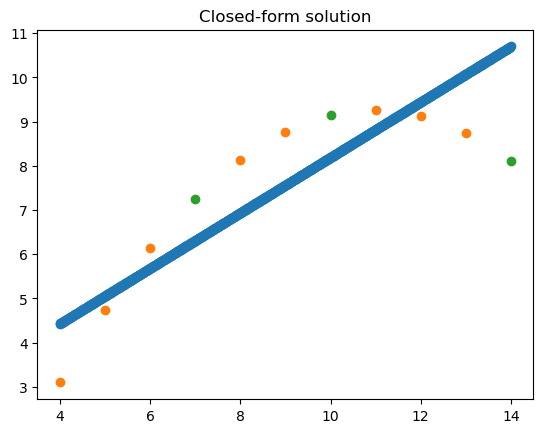

In [85]:
from matplotlib import pyplot as plt
x_plot = torch.Tensor(np.linspace(x.min(), x.max(), 1000)).unsqueeze(1)
y_plot = x_plot @ w_closed_form[0] + w_closed_form[1]
plt.scatter(x_plot, y_plot)
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test)
plt.title("Closed-form solution")
plt.show()

In [86]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.w = torch.nn.Parameter(torch.rand(input_dim, 1))
        
    def forward(self, x):
        return x @ self.w
    
    def compute_gradient(self, x, y):
        y_pred = self.forward(x)
        d_loss_d_y = 2 * (y_pred - y) / len(y)
        d_y_d_w = x
        d_loss_d_w = d_y_d_w.T @ d_loss_d_y
        return d_loss_d_w

In [87]:
# Test case for w_closed_form
def test_w_closed_form():
    # Hardcoded input data
    x_train_test = torch.tensor([[1.0], [2.0], [3.0], [4.0], [5.0]])
    y_train_test = torch.tensor([[3.0], [5.0], [7.0], [9.0], [11.0]])
    
    # Compute the closed-form solution
    X_test = torch.cat([x_train_test, torch.ones_like(x_train_test)], dim=1)
    w_closed_form_test = torch.linalg.inv(X_test.T @ X_test) @ X_test.T @ y_train_test
    
    # Hardcoded expected output
    expected_w_closed_form = torch.tensor([[2.0], [1.0]])
    
    # Check if the computed closed-form solution matches the expected output
    assert torch.allclose(w_closed_form_test, expected_w_closed_form)

# Test case for compute_gradient
def test_compute_gradient():
    # Create an instance of the LinearRegression model
    model = LinearRegression(1)
    
    # Hardcoded input data
    x_test = torch.tensor([[1.0], [2.0], [3.0], [4.0], [5.0]])
    y_test = torch.tensor([[3.0], [5.0], [7.0], [9.0], [11.0]])
    
    # Set the model's parameters to specific values
    model.w.data = torch.tensor([[1.5]])
    
    # Compute the gradient using the compute_gradient method
    gradient = model.compute_gradient(x_test, y_test)
    
    # Hardcoded expected output
    expected_gradient = torch.tensor([[-17.0]])
    
    # Check if the computed gradient matches the expected output
    assert torch.allclose(gradient, expected_gradient)

# Run the test cases
test_w_closed_form()
test_compute_gradient()
print("All test cases passed!")

All test cases passed!


In [88]:
# Augment the input features
x_train_augmented = torch.cat([x_train, torch.ones(len(x_train), 1)], dim=1)
x_test_augmented = torch.cat([x_test, torch.ones(len(x_test), 1)], dim=1)

input_dim = x_train_augmented.shape[1]
model = LinearRegression(input_dim)

num_epochs = 2000
learning_rate = 0.01
losses = []

for epoch in range(1, num_epochs + 1):
    d_loss_d_w = model.compute_gradient(x_train_augmented, y_train)
    
    with torch.no_grad():
        model.w -= learning_rate * d_loss_d_w
    
    with torch.no_grad():
        y_train_pred = model(x_train_augmented)
        y_test_pred = model(x_test_augmented)
        train_error = torch.mean((y_train_pred - y_train) ** 2).item()
        test_error = torch.mean((y_test_pred - y_test) ** 2).item()
        losses.append((train_error, test_error))
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, training error: {train_error:.4f}, test error: {test_error:.4f}")

with torch.no_grad():
    y_train_pred = model(x_train_augmented)
    y_test_pred = model(x_test_augmented)
    train_error_bgd = torch.mean((y_train_pred - y_train) ** 2).item()
    test_error_bgd = torch.mean((y_test_pred - y_test) ** 2).item()

print(f"\nGradient Descent:")
print(f"Training error: {train_error_bgd:.4f}")
print(f"Test error: {test_error_bgd:.4f}")

Epoch 50, training error: 1.1092, test error: 4.3297
Epoch 100, training error: 1.0610, test error: 4.1475
Epoch 150, training error: 1.0229, test error: 3.9892
Epoch 200, training error: 0.9928, test error: 3.8515
Epoch 250, training error: 0.9690, test error: 3.7314
Epoch 300, training error: 0.9503, test error: 3.6266
Epoch 350, training error: 0.9354, test error: 3.5348
Epoch 400, training error: 0.9237, test error: 3.4544
Epoch 450, training error: 0.9144, test error: 3.3839
Epoch 500, training error: 0.9071, test error: 3.3219
Epoch 550, training error: 0.9013, test error: 3.2674
Epoch 600, training error: 0.8968, test error: 3.2193
Epoch 650, training error: 0.8931, test error: 3.1770
Epoch 700, training error: 0.8903, test error: 3.1397
Epoch 750, training error: 0.8880, test error: 3.1067
Epoch 800, training error: 0.8863, test error: 3.0776
Epoch 850, training error: 0.8848, test error: 3.0518
Epoch 900, training error: 0.8837, test error: 3.0290
Epoch 950, training error: 0.

Epoch 1050, training error: 0.8816, test error: 2.9752
Epoch 1100, training error: 0.8812, test error: 2.9611
Epoch 1150, training error: 0.8808, test error: 2.9487
Epoch 1200, training error: 0.8806, test error: 2.9377
Epoch 1250, training error: 0.8803, test error: 2.9279
Epoch 1300, training error: 0.8802, test error: 2.9192
Epoch 1350, training error: 0.8800, test error: 2.9115
Epoch 1400, training error: 0.8799, test error: 2.9047
Epoch 1450, training error: 0.8799, test error: 2.8986
Epoch 1500, training error: 0.8798, test error: 2.8933
Epoch 1550, training error: 0.8797, test error: 2.8885
Epoch 1600, training error: 0.8797, test error: 2.8842
Epoch 1650, training error: 0.8797, test error: 2.8805
Epoch 1700, training error: 0.8796, test error: 2.8771
Epoch 1750, training error: 0.8796, test error: 2.8741
Epoch 1800, training error: 0.8796, test error: 2.8715
Epoch 1850, training error: 0.8796, test error: 2.8692
Epoch 1900, training error: 0.8796, test error: 2.8671
Epoch 1950

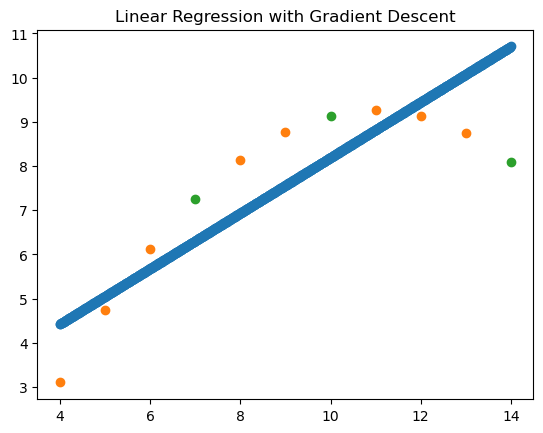

In [89]:
from matplotlib import pyplot as plt
x_plot = torch.Tensor(np.linspace(x.min(), x.max(), 1000)).unsqueeze(1)
y_plot = x_plot @ model.w[0] + model.w[1]
y_plot = y_plot.detach().numpy()
plt.scatter(x_plot, y_plot)
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test)
plt.title("Linear Regression with Gradient Descent")
plt.show()

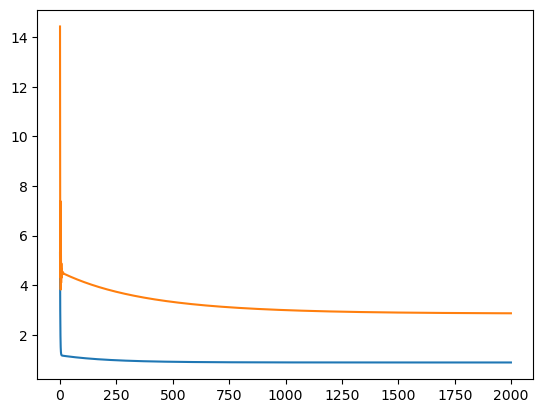

In [90]:
plt.plot(losses)

In [91]:
model_sgd = LinearRegression(input_dim)

num_epochs = 1000
batch_size = 2
learning_rate = 0.001
losses = []

for epoch in range(1, num_epochs + 1):
    for i in range(0, len(x_train), batch_size):
        x_batch = x_train_augmented[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        
        d_loss_d_w = model_sgd.compute_gradient(x_batch, y_batch)
        
        with torch.no_grad():
            model_sgd.w -= learning_rate * d_loss_d_w

    with torch.no_grad():
        y_train_pred = model_sgd(x_train_augmented)
        y_test_pred = model_sgd(x_test_augmented)
        train_error_sgd = torch.mean((y_train_pred - y_train) ** 2).item()
        test_error_sgd = torch.mean((y_test_pred - y_test) ** 2).item()
        losses.append((train_error_sgd, test_error_sgd))

        if epoch % 50 == 0:
            print(f"Epoch: {epoch}, Train error: {train_error_sgd:.4f}, Test error: {test_error_sgd:.4f}")

print(f"\nStochastic Gradient Descent:")
print(f"Training error: {train_error_sgd:.4f}")
print(f"Test error: {test_error_sgd:.4f}")

Epoch: 50, Train error: 1.2238, Test error: 4.9703
Epoch: 100, Train error: 1.1938, Test error: 4.8671
Epoch: 150, Train error: 1.1664, Test error: 4.7697
Epoch: 200, Train error: 1.1415, Test error: 4.6780
Epoch: 250, Train error: 1.1189, Test error: 4.5914
Epoch: 300, Train error: 1.0983, Test error: 4.5096
Epoch: 350, Train error: 1.0796, Test error: 4.4325
Epoch: 400, Train error: 1.0626, Test error: 4.3596
Epoch: 450, Train error: 1.0471, Test error: 4.2907
Epoch: 500, Train error: 1.0331, Test error: 4.2256
Epoch: 550, Train error: 1.0202, Test error: 4.1640
Epoch: 600, Train error: 1.0086, Test error: 4.1058
Epoch: 650, Train error: 0.9980, Test error: 4.0507
Epoch: 700, Train error: 0.9884, Test error: 3.9986
Epoch: 750, Train error: 0.9796, Test error: 3.9492
Epoch: 800, Train error: 0.9717, Test error: 3.9025
Epoch: 850, Train error: 0.9644, Test error: 3.8582
Epoch: 900, Train error: 0.9578, Test error: 3.8163
Epoch: 950, Train error: 0.9518, Test error: 3.7765
Epoch: 1000, 

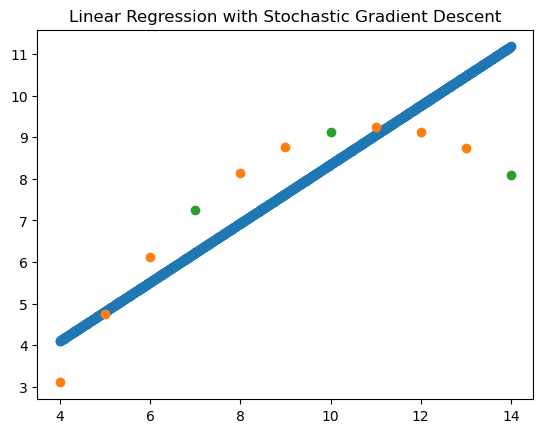

In [92]:
x_plot = torch.Tensor(np.linspace(x.min(), x.max(), 1000)).unsqueeze(1)
y_plot = x_plot @ model_sgd.w[0] + model_sgd.w[1]
y_plot = y_plot.detach().numpy()
plt.scatter(x_plot, y_plot)
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test)
plt.title("Linear Regression with Stochastic Gradient Descent")
plt.show()

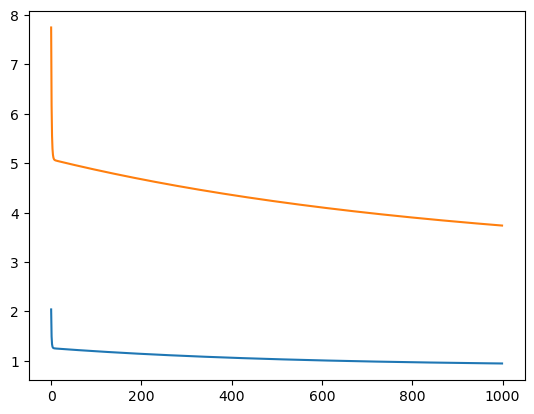

In [93]:
plt.plot(losses)

### Questions: 
1. Compare the MSE values on the test dataset for each algorithm. Are they the same? Why or why not?
2. Apply z-score normalization (which scales the values of a feature to have a mean of 0 and a standard deviation of 1) for the feature and comment whether or not it affect the three algorithms.
3. Apply a polynomial function to augment the feature and compare the MSE values for batch gradient descent. What do you observe?
4. Change the learning rate of the stochastic gradient descent and compare the loss curve. What do you observe?
5. Ridge regression is adding an $L_2$ regularization term to the original objective function of mean squared error. The objective function become following: 
    $$ J(\beta) = \frac{1}{2n} \sum_i \left(x_i^\mathsf{T}\beta - y_i \right)^2 + \frac{\lambda}{2n} \sum_j \beta_j^2 ,$$ 
    where $\lambda \geq 0$, which is a hyper parameter that controls the trade off. Take the derivative of this provided objective function and derive the closed form solution for $\beta$. 

Stochastic Gradient Descent:
Learning rate: 0.001
Training error: 1.0568
Test error: 4.3339

Stochastic Gradient Descent:
Learning rate: 0.0001
Training error: 1.1774
Test error: 4.5902

Stochastic Gradient Descent:
Learning rate: 1e-05
Training error: 2.1062
Test error: 3.9585



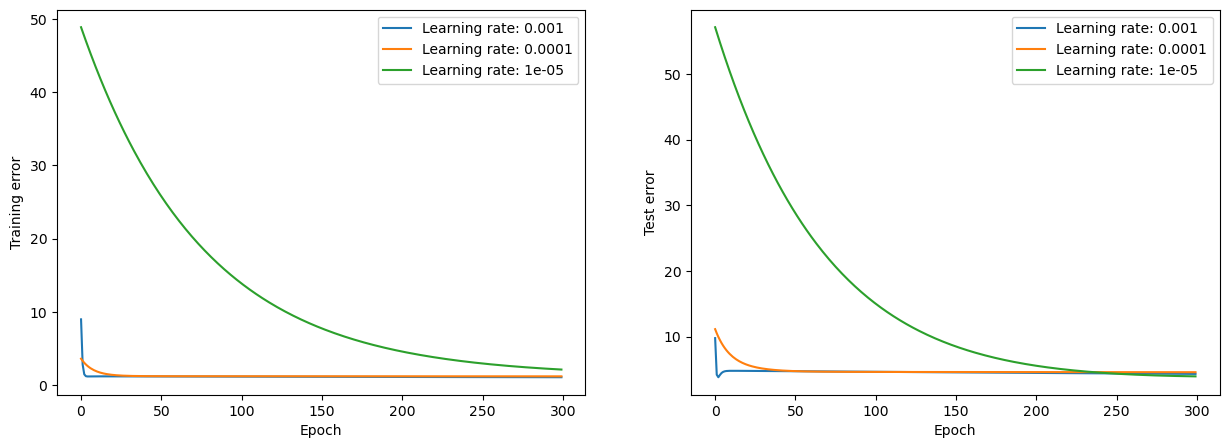

In [107]:
learning_rates = [ 0.001, 0.0001, 0.00001]
num_epochs = 300

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for learning_rate in learning_rates:
    model_sgd = LinearRegression(input_dim)
    train_losses = []
    test_losses = []
    
    for epoch in range(1, num_epochs + 1):
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train_augmented[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]
            
            d_loss_d_w = model_sgd.compute_gradient(x_batch, y_batch)
            
            with torch.no_grad():
                model_sgd.w -= learning_rate * d_loss_d_w

        with torch.no_grad():
            y_train_pred = model_sgd(x_train_augmented)
            y_test_pred = model_sgd(x_test_augmented)
            train_error_sgd = torch.mean((y_train_pred - y_train) ** 2).item()
            test_error_sgd = torch.mean((y_test_pred - y_test) ** 2).item()
            train_losses.append(train_error_sgd)
            test_losses.append(test_error_sgd)

    print(f"Stochastic Gradient Descent:")
    print(f"Learning rate: {learning_rate}")
    print(f"Training error: {train_error_sgd:.4f}")
    print(f"Test error: {test_error_sgd:.4f}")
    print()
    
    axes[0].plot(train_losses, label=f"Learning rate: {learning_rate}")
    axes[1].plot(test_losses, label=f"Learning rate: {learning_rate}")

axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Training error")
axes[0].legend()

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Test error")
axes[1].legend()

plt.show()

In [77]:
def z_score_normalization(x):
    mean = x.mean()
    std = x.std()
    return (x - mean) / std

In [78]:
def polynomial_features(x, degree):
    features = [torch.ones(len(x), 1)]
    for i in range(1, degree + 1):
        features.append(x ** i)
    return torch.cat(features, dim=1)

poly_degree = 2

mean = x.mean()
std = x.std()
x = (x - mean) / std
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

x_train_poly = polynomial_features(x_train, poly_degree)
x_test_poly = polynomial_features(x_test, poly_degree)

In [79]:
input_dim = x_train_poly.shape[1]
model_poly = LinearRegression(input_dim)

num_epochs = 2000
learning_rate = 0.01
losses = []
grad_clip_norm = 1

for epoch in range(1, num_epochs + 1):
    d_loss_d_w = model_poly.compute_gradient(x_train_poly, y_train)
    d_loss_d_w_clipped = torch.clamp(d_loss_d_w, -grad_clip_norm, grad_clip_norm)

    with torch.no_grad():
        model_poly.w -= learning_rate * d_loss_d_w_clipped
    
    with torch.no_grad():
        y_train_pred = model_poly(x_train_poly)
        y_test_pred = model_poly(x_test_poly)
        train_error = torch.mean((y_train_pred - y_train) ** 2).item()
        test_error = torch.mean((y_test_pred - y_test) ** 2).item()
        losses.append((train_error, test_error))
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, training error: {train_error:.4f}, test error: {test_error:.4f}")

with torch.no_grad():
    y_train_pred = model_poly(x_train_poly)
    y_test_pred = model_poly(x_test_poly)
    train_error_bgd = torch.mean((y_train_pred - y_train) ** 2).item()
    test_error_bgd = torch.mean((y_test_pred - y_test)**2).item()

print(f"\nBatch Gradient Descent:")
print(f"Training error: {train_error_bgd:.4f}")
print(f"Test error: {test_error_bgd:.4f}")

Epoch 50, training error: 39.7407, test error: 43.7769
Epoch 100, training error: 30.3070, test error: 33.3241
Epoch 150, training error: 22.8257, test error: 26.4900
Epoch 200, training error: 17.2749, test error: 23.0881
Epoch 250, training error: 13.6680, test error: 22.7757
Epoch 300, training error: 11.3726, test error: 21.9675
Epoch 350, training error: 9.4291, test error: 19.8090
Epoch 400, training error: 7.6825, test error: 17.0196
Epoch 450, training error: 6.1125, test error: 14.0845
Epoch 500, training error: 4.7201, test error: 11.2641
Epoch 550, training error: 3.5090, test error: 8.6896
Epoch 600, training error: 2.4817, test error: 6.4250
Epoch 650, training error: 1.6400, test error: 4.5013
Epoch 700, training error: 1.0504, test error: 3.0027
Epoch 750, training error: 0.6747, test error: 1.9650
Epoch 800, training error: 0.4337, test error: 1.2751
Epoch 850, training error: 0.2788, test error: 0.8238
Epoch 900, training error: 0.1793, test error: 0.5309
Epoch 950, tr

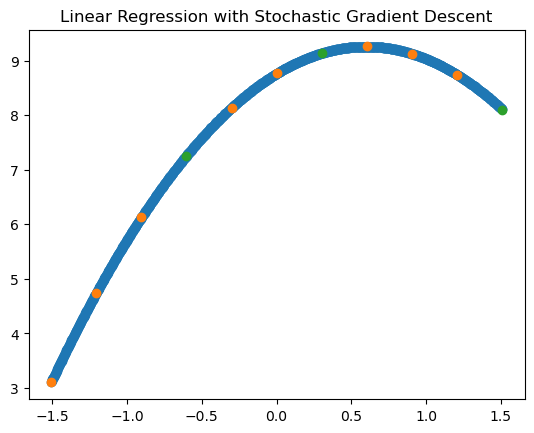

In [80]:
x_plot = torch.Tensor(np.linspace(x.min(), x.max(), 1000)).unsqueeze(1)

x_plot_feat = polynomial_features(x_plot, poly_degree)
y_plot = model_poly(x_plot_feat)
y_plot = y_plot.detach().numpy()
plt.scatter(x_plot, y_plot)
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test)
plt.title("Linear Regression with Stochastic Gradient Descent")
plt.show()

### Your answer here:

1. The MSE values on the test data are slighly different since different optimization algorithms (batch, stochastic, and mini-batch gradient descent) might converge at different rates.

2. Generally, z-score normalization can lead to faster convergence and reduce the chance of getting stuck in local minima. In our case, the final error on the test sets almost remain the same since the weight vector is scaled accordingly.

3. Augmenting features with a polynomial function increases the complexity of the model, allowing for a better fit to the data. The MSE value on the test set is thus lower than that on the original feature set. Actually combining z-score normalization with polynomial features can lead to perfect fit of the given data (with a test error of zero).

4. The learning rate controls how big a step the algorithm takes towards the minimum. If it is too small, convergence can be slow; if it is too large, the algorithm might overshoot the minimum or diverge. 

5. The objective function $J(\beta)$ with respect to $\beta$ is given by: 
    $$ J(\beta) = \frac{1}{2n} \sum_i \left(x_i^\mathsf{T}\beta - y_i \right)^2 + \frac{\lambda}{2n} \sum_j \beta_j^2 ,$$ 
    where $\lambda \geq 0$, which is a hyper parameter that controls the trade off.
    We can rewrite the objective function in matrix form as:
    $$ J(\beta) = \frac{1}{2n} (X\beta - y)^\mathsf{T}(X\beta - y) + \frac{\lambda}{2n} \beta^\mathsf{T}\beta,$$
    where $X = [x_1, x_2, \ldots, x_n]^\mathsf{T}$ is the design matrix and $y = [y_1, y_2, \ldots, y_n]^\mathsf{T}$ is the target vector.
    
    The derivative of the objective function $J(\beta)$ with respect to $\beta$ is given by:
    $$ \nabla J(\beta) = \frac{1}{n} X^\mathsf{T}(X\beta - y) + \frac{\lambda}{n} \beta.$$
    The closed form solution for $\beta$ is given by:
    $$ \beta = (X^\mathsf{T}X + \lambda I)^{-1}X^\mathsf{T}y.$$